# Load Packages

In [1]:
# Main modules 
import torch
from torch import Generator
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from frogfunctions import Model 
from frogfunctions import setup_seed, train_loop, test_loop, train_model, plot_probabilities

In [2]:
# Dataframe output format
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Set random seed for reproduction

In [3]:
SEED = 42
setup_seed(SEED)

# Import data

In [4]:
data_dir = "../data/"

In [5]:
# Download and load the training data
dataset_all = ImageFolder(data_dir, transform=torchvision.transforms.ToTensor())

# Print number in full data set
size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all) = {size_all}')

# Split into Test, Validation, and Training
size_test = int(size_all * 0.15)
size_val = int(size_all * 0.15)
size_train = size_all - size_test - size_val
dataset_test, dataset_val, dataset_train = random_split(dataset_all, [size_test, size_val, size_train], 
                                                        generator=Generator().manual_seed(SEED))

print(f'After splitting the full dataset into test, validation, and training: \n \
      len(dataset_test) = {len(dataset_test)} \n \
      len(dataset_val) = {len(dataset_val)} \n \
      len(dataset_train) = {len(dataset_train)}')

Before splitting the full dataset into train and test: len(dataset_all) = 700
After splitting the full dataset into test, validation, and training: 
       len(dataset_test) = 105 
       len(dataset_val) = 105 
       len(dataset_train) = 490


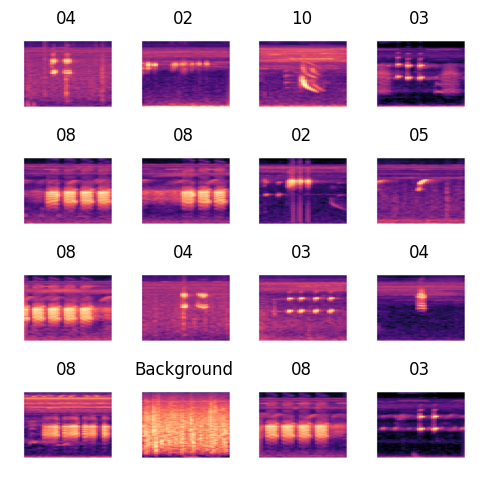

In [6]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['02', '03', '04', '05', '08', '10', 'Background']

# Rows and columns are set to fit one training batch (16)
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# Prepare data

In [7]:
# Define batch size
batch_size = 16

In [8]:
# Load data into DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_val)}

# Define parameters for model

In [9]:
# Define number of classes
num_classes = 7

In [10]:
# Create model 
model = Model(num_classes=num_classes).to(device)

In [11]:
# Define hyperparameters
learning_rate = 0.001
weight_decay = 0.006
momentum=0.09

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

# Train model

Epoch 1
-------------------------------
loss: 1.956831  [   16/  490]
Training Error: Accuracy: 22.2%
Validation Error: Accuracy: 21.9%, Avg loss: 1.943265 

Epoch 2
-------------------------------
loss: 1.943460  [   16/  490]
Training Error: Accuracy: 30.4%
Validation Error: Accuracy: 36.2%, Avg loss: 1.909547 

Epoch 3
-------------------------------
loss: 1.904180  [   16/  490]
Training Error: Accuracy: 36.9%
Validation Error: Accuracy: 40.0%, Avg loss: 1.886494 

Epoch 4
-------------------------------
loss: 1.905344  [   16/  490]
Training Error: Accuracy: 44.1%
Validation Error: Accuracy: 44.8%, Avg loss: 1.851498 

Epoch 5
-------------------------------
loss: 1.830580  [   16/  490]
Training Error: Accuracy: 47.8%
Validation Error: Accuracy: 51.4%, Avg loss: 1.831491 

Epoch 6
-------------------------------
loss: 1.817395  [   16/  490]
Training Error: Accuracy: 52.9%
Validation Error: Accuracy: 55.2%, Avg loss: 1.785700 

Epoch 7
-------------------------------
loss: 1.7620

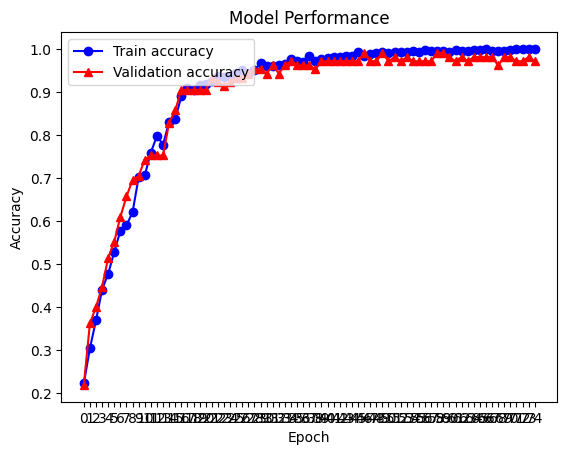

In [12]:
# Set number of epochs 
epochs = 75

# Train
train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)

# Load model

In [15]:
import os
os.getcwd()

'/sfs/qumulo/qhome/xje4cy/modeling/notebooks'

In [17]:
PATH = '../saved_models/epoch=46_accuracy=99.0%'
model = Model(num_classes=7).to(device)
model.load_state_dict(torch.load(PATH))
model.eval();

In [18]:
# Test accuracy
test_loop(test_dataloader, model, loss_fn, 'test')

Test Error: Accuracy: 97.1%, Avg loss: 0.073284 



In [19]:
# Class prediction probabilities
predictions = test_loop(test_dataloader, model, loss_fn, 'prob')
predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.039471,0.006983,0.928799,0.002671,0.005545,0.004949,0.011583
1,0.030488,0.001833,0.958358,0.001428,0.000797,0.002377,0.004718
2,0.000885,0.000003,0.000555,0.000057,0.001163,0.005128,0.992209
3,0.000032,0.000296,0.000049,0.000003,0.985886,0.010962,0.002772
4,0.000017,0.000382,0.000042,0.000002,0.996773,0.001958,0.000826


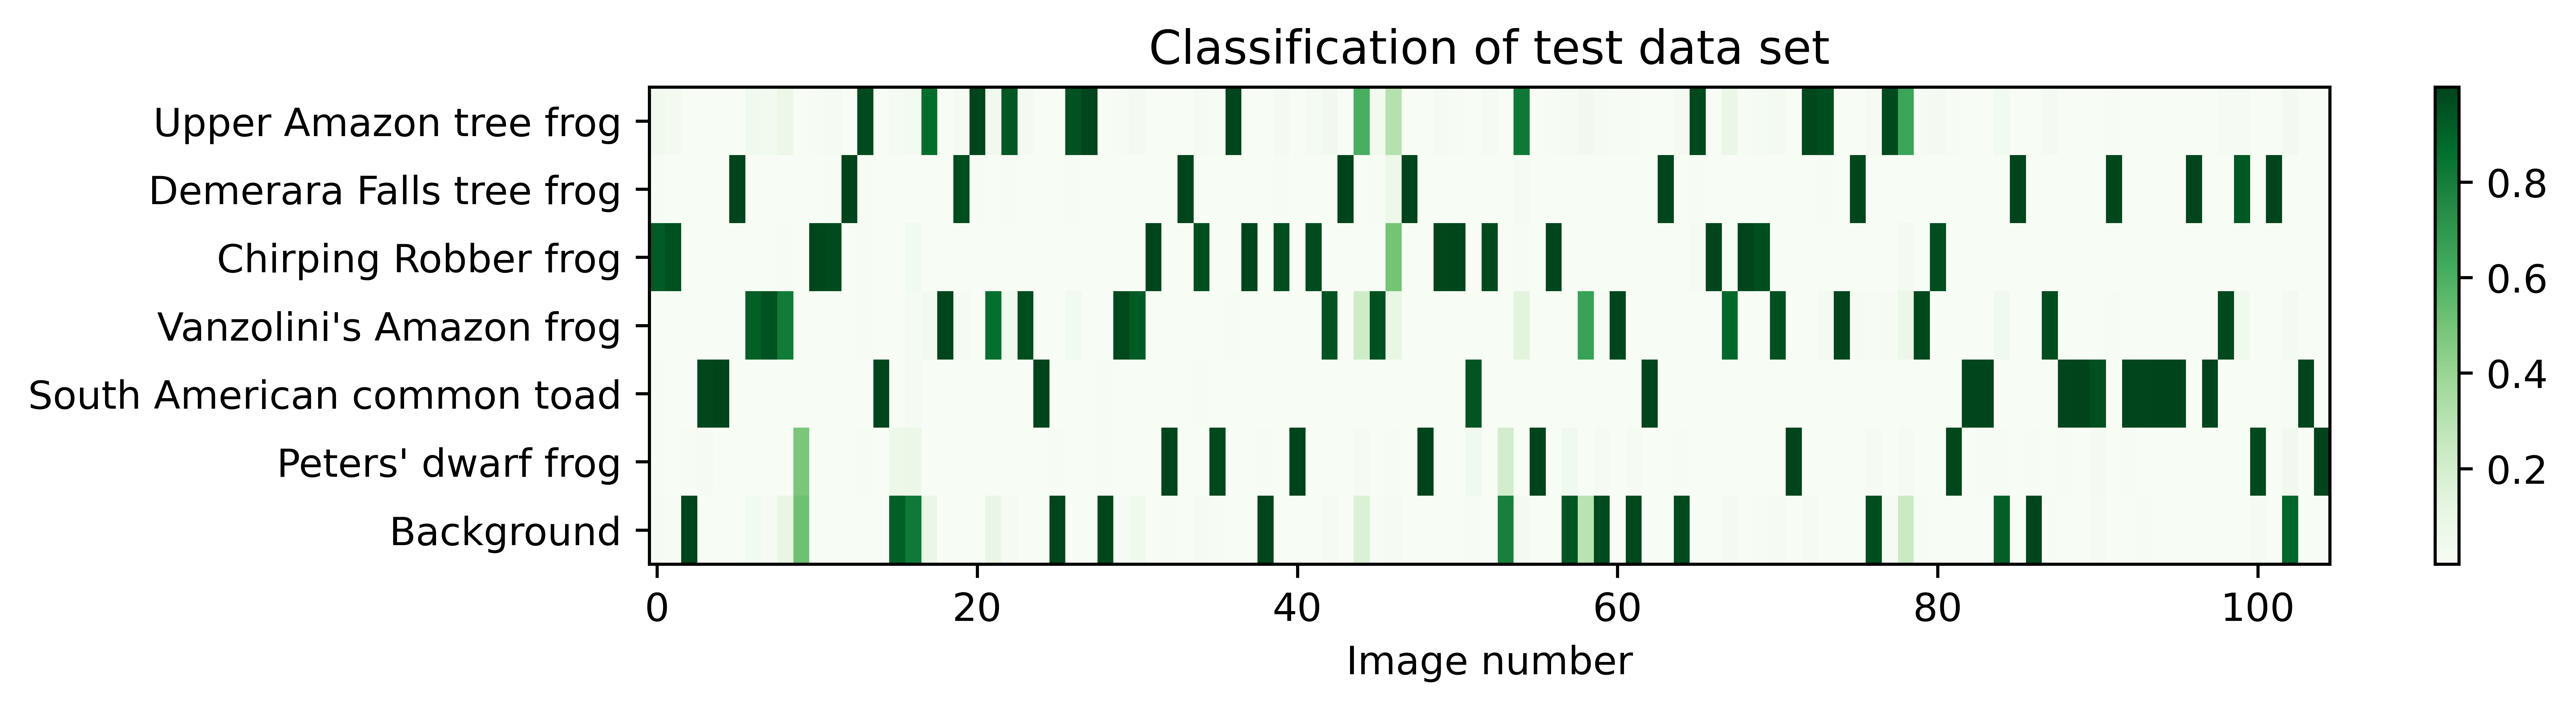

In [20]:
# Plot probabilities
plot_probabilities(predictions, title='Classification of test data set', xlabel='Image number')

----

# Test model on long audio files (Ex. 1)

In [21]:
test1_dir = "../test_data/city/"

In [22]:
# Download and load the training data
test1 = ImageFolder(test1_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test1_dataloader = DataLoader(test1, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test1_predictions = test_loop(test1_dataloader, model, loss_fn, 'prob')
test1_predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.057408,0.001363,0.072040,0.017853,0.015341,0.013865,0.822130
1,0.036561,0.001137,0.034124,0.009047,0.026645,0.015605,0.876882
2,0.029781,0.001598,0.052754,0.009024,0.040236,0.021921,0.844687
3,0.090224,0.001789,0.074580,0.041635,0.009890,0.011988,0.769894
4,0.297520,0.000163,0.002176,0.193351,0.000117,0.000959,0.505714


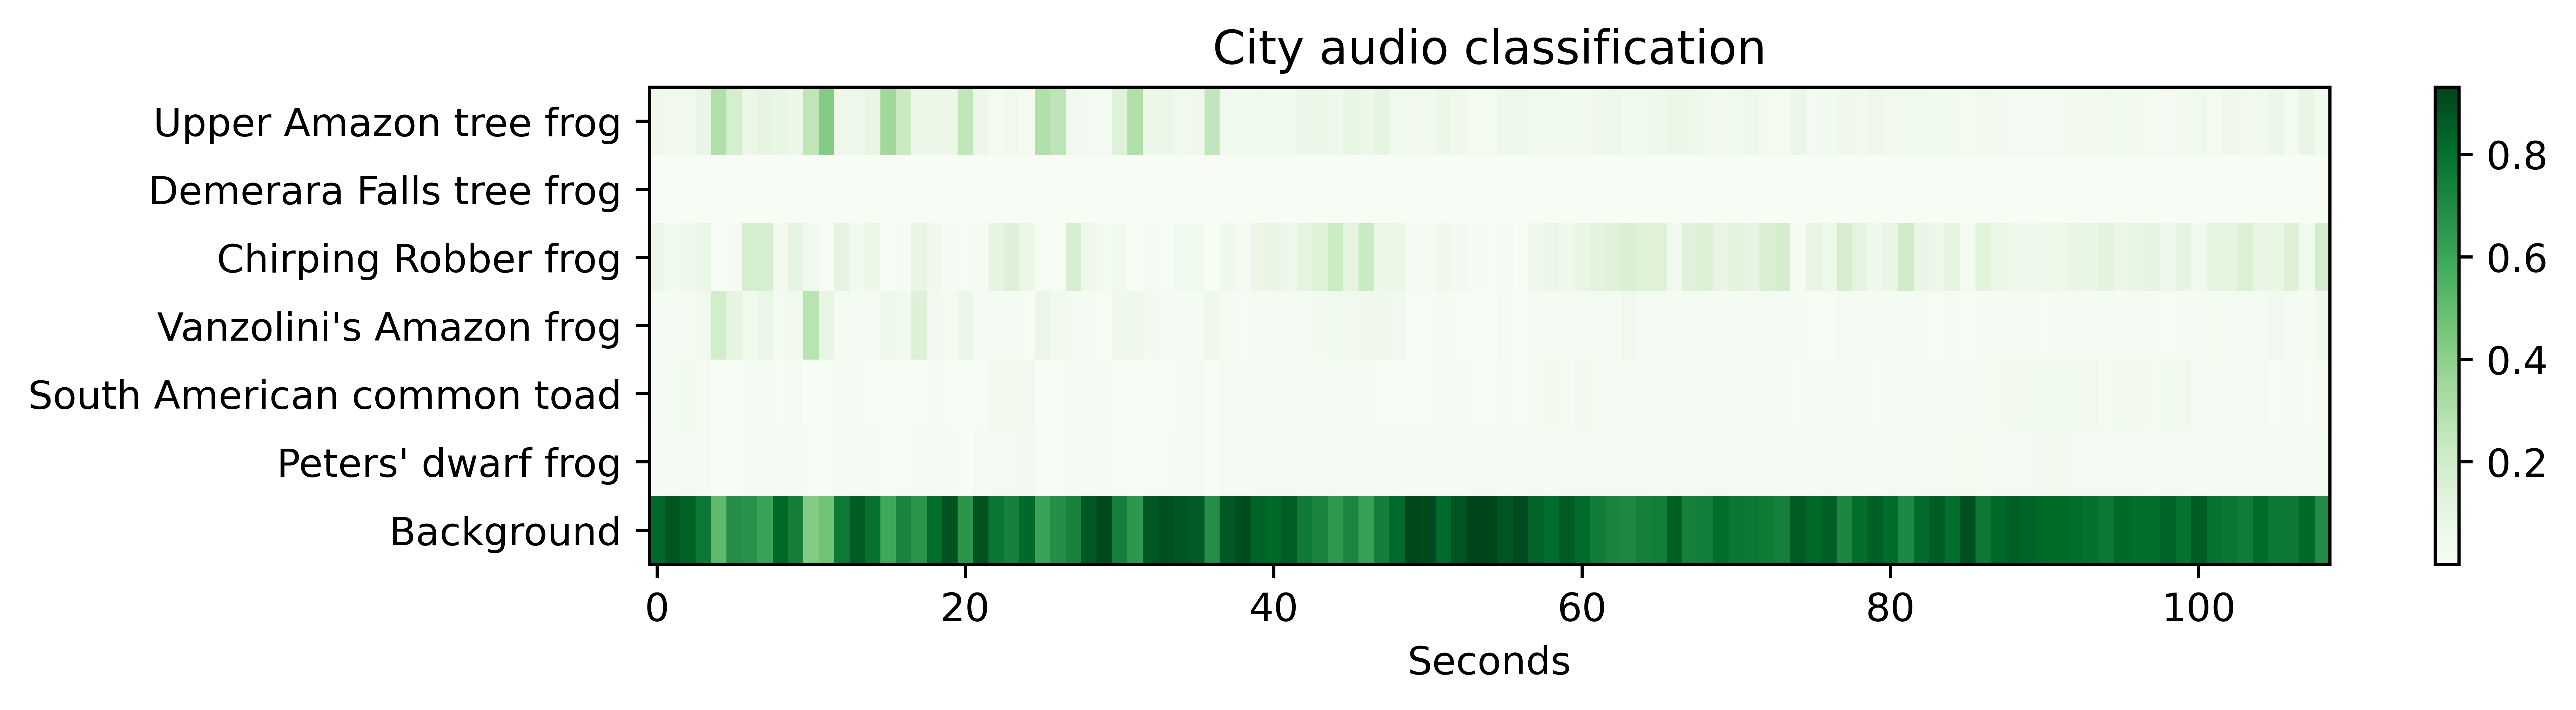

In [23]:
# Plot probabilities
plot_probabilities(test1_predictions, title='City audio classification', xlabel='Seconds')

# Test model on long audio files (Ex. 2)

In [24]:
test2_dir = "../test_data/long/"

In [25]:
# Download and load the training data
test2 = ImageFolder(test2_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test2_dataloader = DataLoader(test2, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test2_predictions = test_loop(test2_dataloader, model, loss_fn, 'prob')
test2_predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.198340,0.000508,0.002274,0.045363,0.001342,0.012317,0.739855
1,0.136614,0.000218,0.001161,0.030026,0.000711,0.011818,0.819453
2,0.765787,0.005948,0.048196,0.049565,0.004343,0.018371,0.107790
3,0.615859,0.003305,0.026120,0.046869,0.004607,0.020484,0.282755
4,0.709554,0.003277,0.034170,0.030044,0.003139,0.015721,0.204094


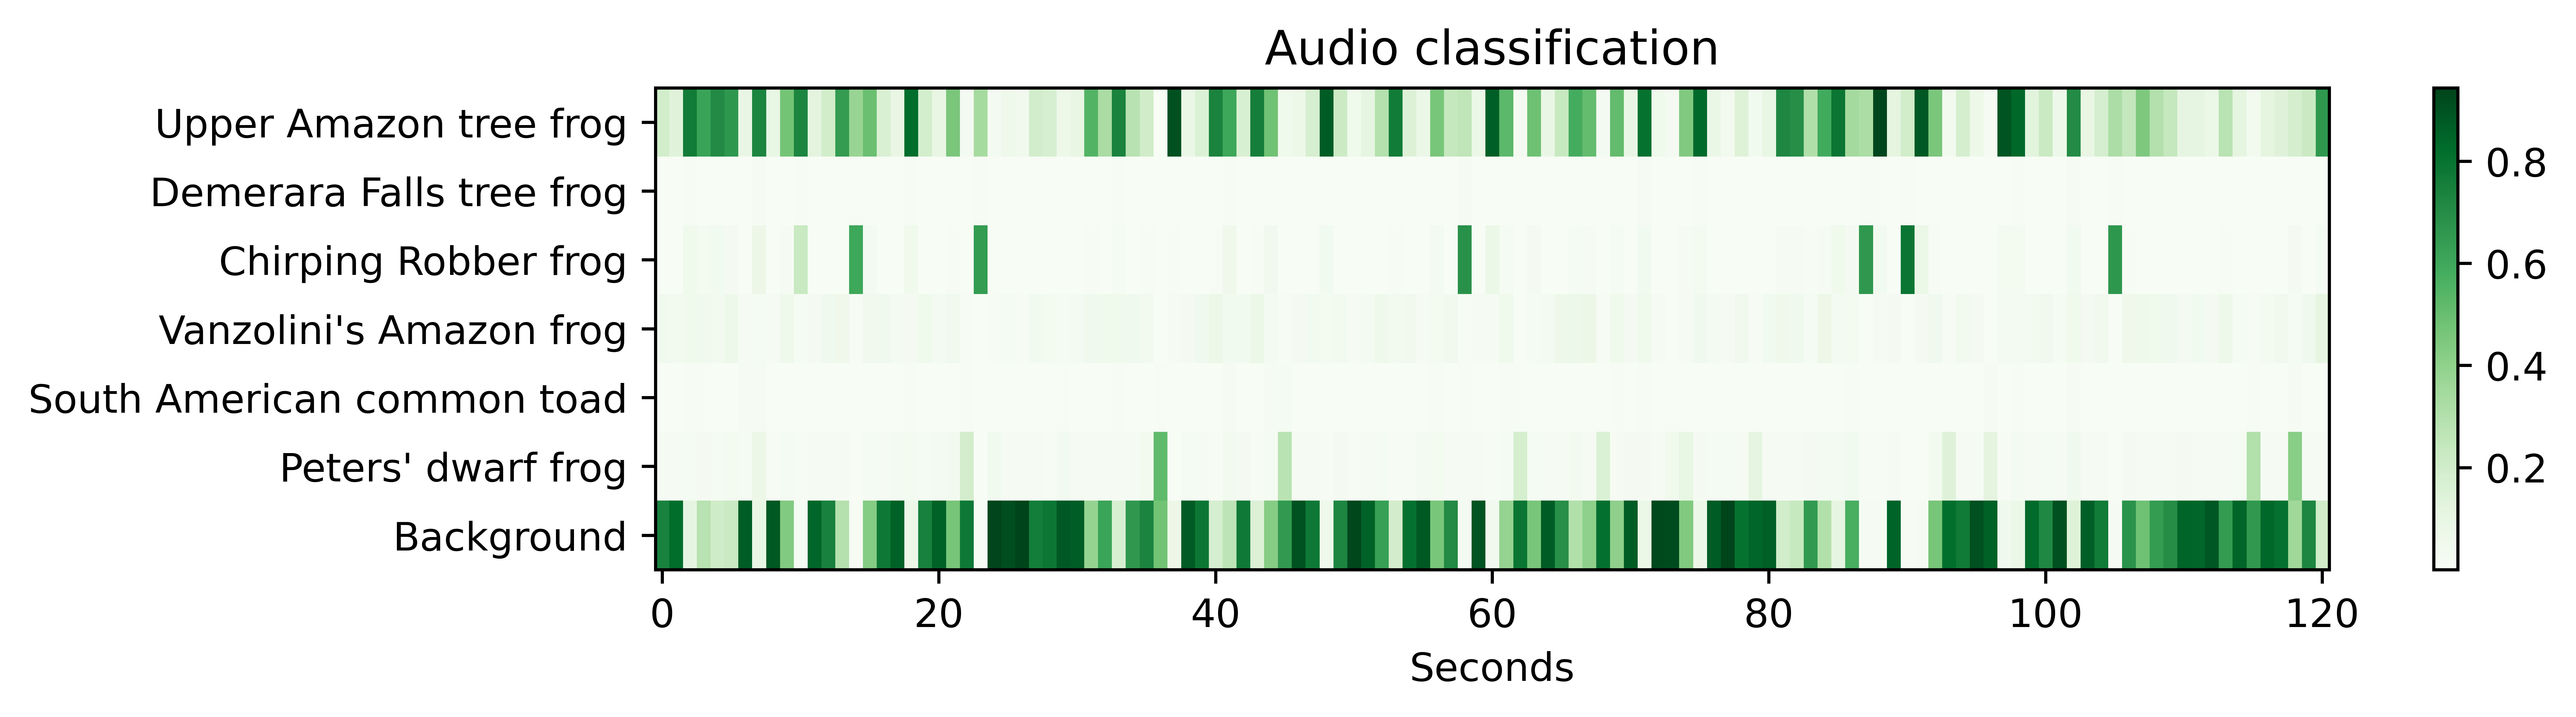

In [26]:
# Plot probabilities
plot_probabilities(test2_predictions, title='Audio classification', xlabel='Seconds')

# Test Model on Long Audio Files (Ex.3)

In [ ]:
test3_02_dir = '../test_data/species_02'

# Download and load the training data
test3_02 = ImageFolder(test3_02_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test3_02_dataloader = DataLoader(test3_02, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test3_02_predictions = test_loop(test3_02_dataloader, model, loss_fn, 'prob')
test3_02_predictions.head()

In [ ]:
# Plot probabilities
plot_probabilities(test3_02_predictions, title='Audio classification', xlabel='Seconds')

In [ ]:
test3_03_dir = '../test_data/species_03'

# Download and load the training data
test3_03 = ImageFolder(test3_03_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test3_03_dataloader = DataLoader(test3_03, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test3_03_predictions = test_loop(test3_03_dataloader, model, loss_fn, 'prob')
test3_03_predictions.head()

In [ ]:
# Plot probabilities
plot_probabilities(test3_03_predictions, title='Audio classification', xlabel='Seconds')

In [ ]:
test3_04_dir = '../test_data/species_04'

# Download and load the training data
test3_04 = ImageFolder(test3_04_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test3_04_dataloader = DataLoader(test3_04, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test3_04_predictions = test_loop(test3_04_dataloader, model, loss_fn, 'prob')
test3_04_predictions.head()

In [ ]:
# Plot probabilities
plot_probabilities(test3_04_predictions, title='Audio classification', xlabel='Seconds')

In [ ]:
test3_05_dir = '../test_data/species_05'

# Download and load the training data
test3_05 = ImageFolder(test3_05_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test3_05_dataloader = DataLoader(test3_05, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test3_05_predictions = test_loop(test3_05_dataloader, model, loss_fn, 'prob')
test3_05_predictions.head()

In [ ]:
# Plot probabilities
plot_probabilities(test3_05_predictions, title='Audio classification', xlabel='Seconds')

In [ ]:
test3_08_dir = '../test_data/species_08'

# Download and load the training data
test3_08 = ImageFolder(test3_08_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test3_08_dataloader = DataLoader(test3_08, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test3_08_predictions = test_loop(test3_08_dataloader, model, loss_fn, 'prob')
test3_08_predictions.head()

In [ ]:
# Plot probabilities
plot_probabilities(test3_08_predictions, title='Audio classification', xlabel='Seconds')

In [ ]:
test3_10_dir = '../test_data/species_10'

# Download and load the training data
test3_10 = ImageFolder(test3_10_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test3_10_dataloader = DataLoader(test3_10, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test3_10_predictions = test_loop(test3_10_dataloader, model, loss_fn, 'prob')
test3_10_predictions.head()

In [ ]:
# Plot probabilities
plot_probabilities(test3_10_predictions, title='Audio classification', xlabel='Seconds')